In [ ]:
# Everytime I run these notebooks I get the following warning:
# "The selected GPU type was not available. You are now connected to a T4".
# It seems that's something set in the notebook settings as it offers me to open it

#!pip install datasets 'tensorflow==2.15'
!pip show tensorflow # This notebook was designed for version 2.15 (which seems to be not available), so I'm going to try run it with the default installed version 2.19

Name: tensorflow
Version: 2.19.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tensorflow_decision_forests, tf_keras


In [2]:
# Everytime I run these notebooks I get the following warning:
# "The selected GPU type was not available. You are now connected to a T4".
# It seems that's something set in the notebook settings as it offers me to open it

#!pip install datasets 'tensorflow==2.15'
# Show the installed version of TensorFlow. This notebook was designed for version 2.15 (which seems to be not available), so I'm going to try run it with the default installed version 2.19
!pip show tensorflow

!pip install gensim # Because I was getting "ModuleNotFoundError: No module named 'gensim'" in line 6 "from gensim.models import Word2Vec"
# Note: It forced a re-start after the installation of new versions of numpy,scipy (to be compatible with gensim 4.3.3, the current version of gensim at Oct 6 2025)

# Import the tensorflow library
import tensorflow as tf
# Import necessary layers from tensorflow.keras
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LayerNormalization, MultiHeadAttention, Layer, TextVectorization, BatchNormalization
# Import the Model class from tensorflow.keras
from tensorflow.keras.models import Model
# Import EarlyStopping callback
from tensorflow.keras.callbacks import EarlyStopping
# Import the load_dataset function from the datasets library (from Hugging Face)
from datasets import load_dataset
# Import the numpy library for numerical operations
import numpy as np
# Import the matplotlib.pyplot library for plotting
import matplotlib.pyplot as plt
# Import the Word2Vec model from the gensim library
from gensim.models import Word2Vec
# This command makes matplotlib plots appear inline within the notebook
%matplotlib inline


# Load TweetEval dataset (irony subset) using the load_dataset function
# The line "from datasets import load_dataset", is directly importing the function load_dataset
#  from the datasets library. When you import a function this way, you can use it directly by its name
# without needing to reference the library prefix.
data = load_dataset("tweet_eval", "irony")

# Display the structure of the loaded dataset
print(data)

# Display an example from the training set
print("\nExample from the training set:")
print(data["train"][0])

# Preprocess data for training
# Extract text data from the training split
train_texts = data["train"]["text"]
# Convert training labels to one-hot encoded format
train_labels = tf.keras.utils.to_categorical(np.array(data["train"]["label"]), num_classes=2)

# Preprocess data for testing
# Extract text data from the test split
test_texts = data["test"]["text"]
# Convert test labels to one-hot encoded format
test_labels = tf.keras.utils.to_categorical(np.array(data["test"]["label"]), num_classes=2)

# Debugging: Check label distributions in the training set
print(f"Training labels distribution: {np.sum(train_labels, axis=0)}")
# Debugging: Check label distributions in the test set
print(f"Test labels distribution: {np.sum(test_labels, axis=0)}")

# Train a Word2Vec model using gensim
# Split training texts into lists of words (sentences for Word2Vec)
sentences = [text.split() for text in train_texts]
# Initialize and train the Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4)
# Save the trained Word2Vec model to a file
word2vec_model.save("word2vec.model")

# Create an embedding matrix from the trained Word2Vec model
# Get the vocabulary (list of words) from the Word2Vec model
word2vec_vocab = word2vec_model.wv.index_to_key
# Initialize an embedding matrix with zeros. Add 1 for padding/unknown token.
embedding_matrix = np.zeros((len(word2vec_vocab)+1, 300))
# Create a mapping from words to their indices in the embedding matrix
word_index_map = {word: idx + 1 for idx, word in enumerate(word2vec_vocab)}
# Fill the embedding matrix with vectors from the Word2Vec model
for word, idx in word_index_map.items():
    embedding_matrix[idx] = word2vec_model.wv[word]

# Define a function to map text tokens to their Word2Vec indices
def map_to_word2vec_indices(text, word_index_map):
    # Split the input text into tokens (words)
    tokens = text.split()
    # Return a list of indices, using 0 for tokens not found in the map
    return [word_index_map.get(token, 0) for token in tokens]

# Define a function to create TensorFlow datasets
def create_tf_dataset(texts, labels, word_index_map, max_length=100):
    # Tokenize texts using the mapping function
    tokenized_texts = [map_to_word2vec_indices(text, word_index_map) for text in texts]
    # Pad the tokenized sequences to a fixed maximum length
    padded_texts = tf.keras.preprocessing.sequence.pad_sequences(tokenized_texts, maxlen=max_length, padding='post')
    # Create a TensorFlow dataset from the padded sequences and labels
    return tf.data.Dataset.from_tensor_slices((padded_texts, labels))

# Create TensorFlow datasets for training and testing
train_dataset = create_tf_dataset(train_texts, train_labels, word_index_map)
test_dataset = create_tf_dataset(test_texts, test_labels, word_index_map)

# Debugging: Check dataset shapes by taking one batch
for batch in train_dataset.take(1):
    # Print the shape of the input (padded sequences) and the label
    print(f"Sample input shape: {batch[0].shape}, Sample label shape: {batch[1].shape}")

# Prepare datasets for training by shuffling, batching, and prefetching
# Shuffle the training dataset for better training
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(256).prefetch(tf.data.AUTOTUNE)
# Batch and prefetch the test dataset
test_dataset = test_dataset.batch(256).prefetch(tf.data.AUTOTUNE)

Name: tensorflow
Version: 2.19.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tensorflow_decision_forests, tf_keras
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2862
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 784
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 955
    })
})

Example from the training set:
{'text': 'seeing ppl walking w/ crutches makes me really excited for the next 3 weeks of my life', 'lab

In [3]:
def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] * np.arange(d_model)[np.newaxis, :] * (1 / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model)))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return tf.cast(angle_rads[np.newaxis, ...], dtype=tf.float32)

class TransformerBlock(Layer):
    def __init__(self, d_model, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(d_model)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output, attention_scores = self.att(inputs, inputs, return_attention_scores=True)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output), attention_scores

In [5]:
# Custom embedding layer
class PretrainedEmbedding(Layer):
    def __init__(self, embedding_matrix):
        super(PretrainedEmbedding, self).__init__()
        self.embedding = Embedding(
            input_dim=embedding_matrix.shape[0],
            output_dim=embedding_matrix.shape[1],
            weights=[embedding_matrix],
            trainable=False
        )

    def call(self, x):
        return self.embedding(x)

# Model Hyperparameters
d_model = 300
num_heads = 8
ff_dim = 1024
num_classes = 2

# Build the Model
inputs = Input(shape=(100,))
embedding_layer = PretrainedEmbedding(embedding_matrix)
embeddings = embedding_layer(inputs)

# Add Transformer Blocks
transformer_block1 = TransformerBlock(d_model, num_heads, ff_dim)
transformer_block2 = TransformerBlock(d_model, num_heads, ff_dim)
transformer_block3 = TransformerBlock(d_model, num_heads, ff_dim)
 # ,training=true, added by Gemini to fix the missing a required argument: 'training' error in the next few lines
x, attn_weights1 = transformer_block1(embeddings, training=True)
x = BatchNormalization()(x)
x, attn_weights2 = transformer_block2(x, training=True)
x = BatchNormalization()(x)
x, attn_weights3 = transformer_block3(x, training=True)
x = BatchNormalization()(x)

# Classification Head
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = Dropout(0.15)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.15)(x)
outputs = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)

# Model Summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pretrained_embedding_1          │ (None, 100, 300)       │     3,768,300 │
│ (PretrainedEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ [(None, 100, 300),     │     3,504,424 │
│ (TransformerBlock)              │ (None, 8, 100, 100)]   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 300)       │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_4             │ [(None, 100, 300),     │     3,504,424 │
│ (TransformerBlock)              │ (None, 8, 100, 100)]   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 300)       │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_5             │ [(None, 100, 300),     │     3,504,424 │
│ (TransformerBlock)              │ (None, 8, 100, 100)]   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100, 300)       │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 300)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       154,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,440,310 (55.09 MB)

 Trainable params: 10,670,210 (40.70 MB)

 Non-trainable params: 3,770,100 (14.38 MB)

In [6]:
# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Add EarlyStopping
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train the Model
model.fit(train_dataset, epochs=50, validation_data=test_dataset, callbacks=[early_stopping])

# Evaluate the Model
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy}")

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.5123 - loss: 0.7959 - val_accuracy: 0.3967 - val_loss: 0.9915
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 701ms/step - accuracy: 0.4975 - loss: 0.7084 - val_accuracy: 0.4235 - val_loss: 0.9979
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 715ms/step - accuracy: 0.5194 - loss: 0.7009 - val_accuracy: 0.3967 - val_loss: 0.9947
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 731ms/step - accuracy: 0.5392 - loss: 0.6983 - val_accuracy: 0.3967 - val_loss: 1.0285
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 736ms/step - accuracy: 0.5457 - loss: 0.6934 - val_accuracy: 0.3967 - val_loss: 0.9966
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 724ms/step - accuracy: 0.5396 - loss: 0.6911 - val_accuracy: 0.3967 - val_loss: 1.0122
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.3923 - loss: 0.9934
Test Accuracy: 0.3966836631298065


In [7]:
# Manual Testing
ironic_phrases = ["Oh great, another Monday.", "This is exactly what I needed right now."]
non_ironic_phrases = ["I love sunny weather.", "This meal is delicious."]

test_phrases = ironic_phrases + non_ironic_phrases

test_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    [map_to_word2vec_indices(text, word_index_map) for text in test_phrases], maxlen=100, padding='post'
)

# Debugging: Check dimensions of manual test input
print(f"Manual test data shape: {test_sequences.shape}")

predictions = model.predict(test_sequences)
for phrase, pred in zip(test_phrases, predictions):
    label = "Ironic" if np.argmax(pred) == 1 else "Non-Ironic"
    print(f"Phrase: '{phrase}' - Predicted Label: {label}")

Manual test data shape: (4, 100)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Phrase: 'Oh great, another Monday.' - Predicted Label: Ironic
Phrase: 'This is exactly what I needed right now.' - Predicted Label: Ironic
Phrase: 'I love sunny weather.' - Predicted Label: Ironic
Phrase: 'This meal is delicious.' - Predicted Label: Ironic


In the video the non-ironic phrases were correctly identified. I guess the difference is caused by the use of more recent versions of the libraries, or by the fix done by Gemini above (, training=True)
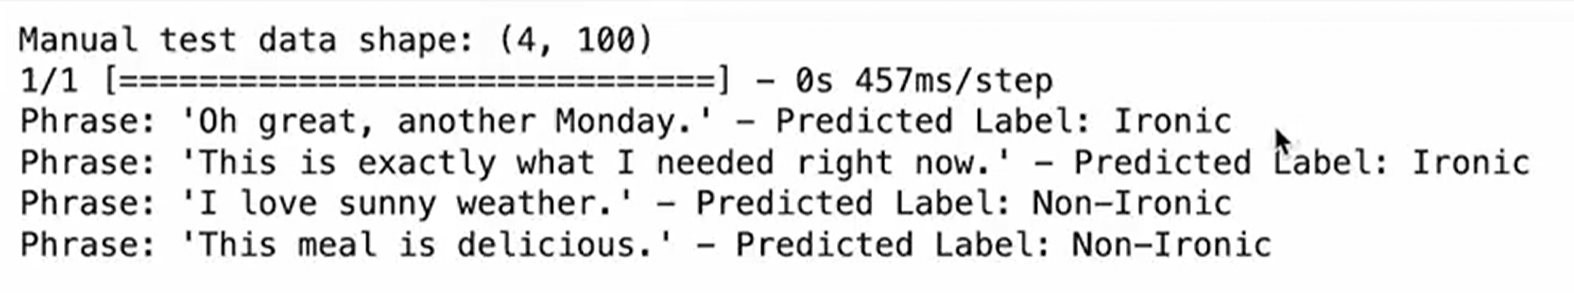

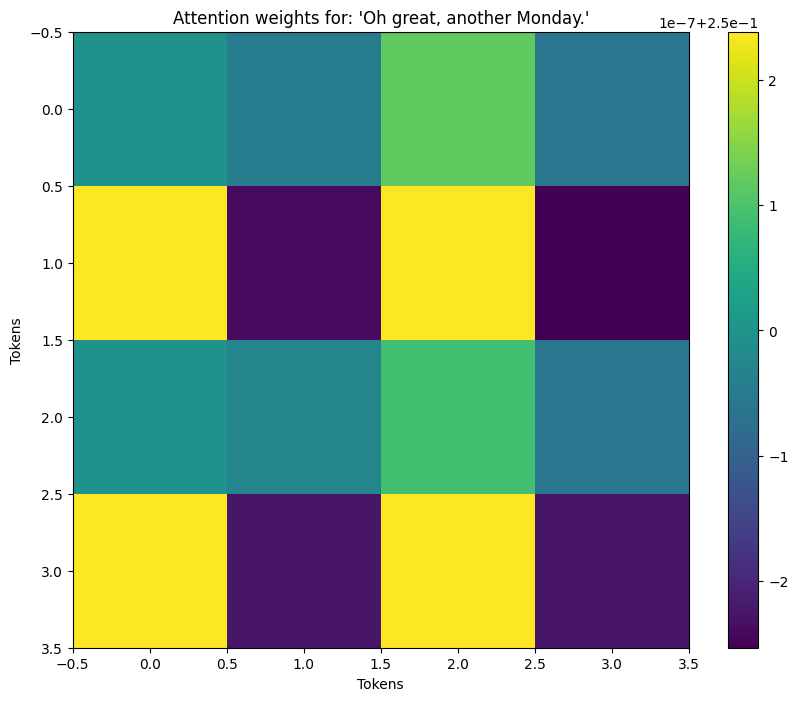

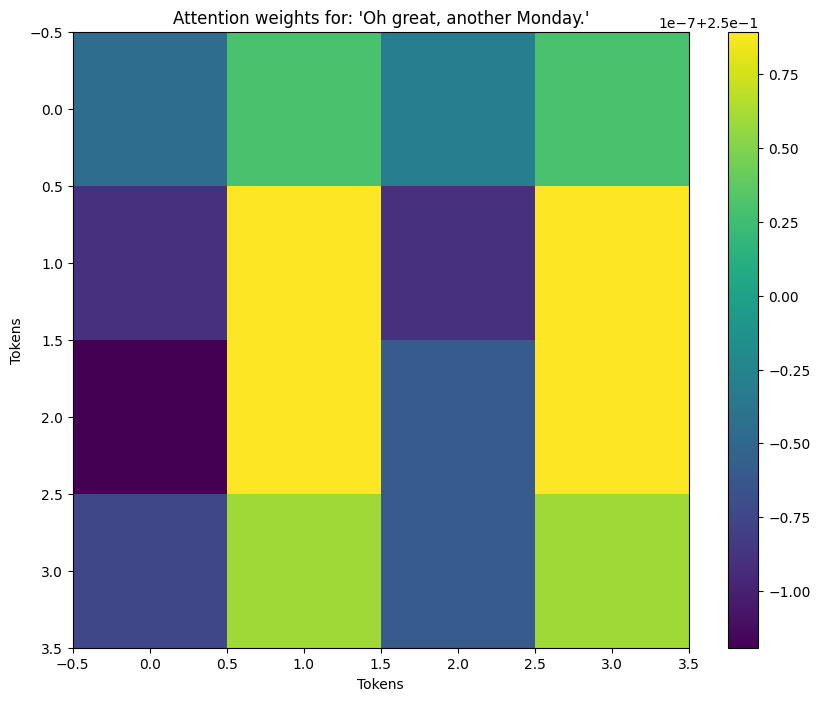

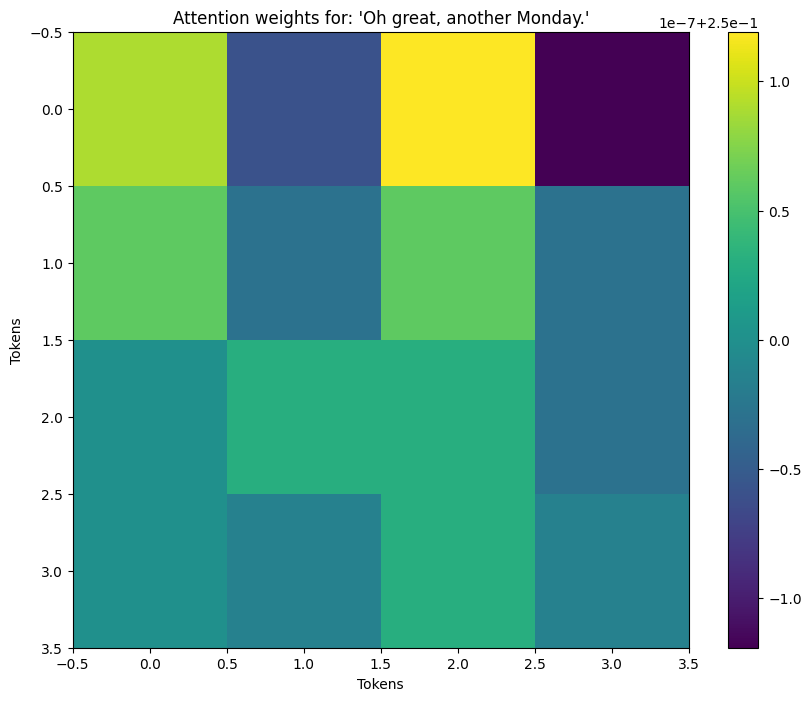

In [9]:
# Visualize Attention Weights
def visualize_attention(inputs, attention_weights, input_text):
    attention_weights = tf.reduce_mean(attention_weights, axis=1).numpy().squeeze()  # Average over heads and squeeze batch

    plt.figure(figsize=(10, 8))
    plt.imshow(attention_weights, cmap='viridis')
    plt.colorbar()
    plt.title(f"Attention weights for: '{input_text}'")
    plt.xlabel("Tokens")
    plt.ylabel("Tokens")
    plt.show()

# Select a manual test input to visualize attention
selected_text = "Oh great, another Monday."
selected_sequence = tf.constant(tf.keras.preprocessing.sequence.pad_sequences(
    [map_to_word2vec_indices(selected_text, word_index_map)], maxlen=len(selected_text.split()), padding='post'))

# Pass through transformer blocks and visualize attention
# , training=True added manually to fix the "e have a positional argument to process" following
# the example of the fix Gemini did above
_, attn_weights1 = transformer_block1(embedding_layer(selected_sequence), training=True)
visualize_attention(selected_sequence, attn_weights1, selected_text)

_, attn_weights2 = transformer_block2(embedding_layer(selected_sequence), training=True)
visualize_attention(selected_sequence, attn_weights2, selected_text)

_, attn_weights3 = transformer_block3(embedding_layer(selected_sequence), training=True)
visualize_attention(selected_sequence, attn_weights3, selected_text)
